## Fitting a Reinforcement Learning Model to Behavioral Data with PyMC
* https://www.pymc.io/projects/examples/en/latest/case_studies/reinforcement_learning.html

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

from matplotlib.lines import Line2D

In [5]:
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

### Generate fake data
* 이것이 마치 동물 실험 결과인듯 취급할 것이다.

In [7]:
def generate_data(rng, alpha, beta, n=100, p_r=None):
    if p_r is None:
        p_r = [0.4, 0.6]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta * Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([0, 1], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs


In [8]:
true_alpha = 0.5 # learning rate of delta rule
true_beta = 5 # inverse temperature of softmax policy
n = 150
actions, rewards, Qs = generate_data(rng, true_alpha, true_beta, n)

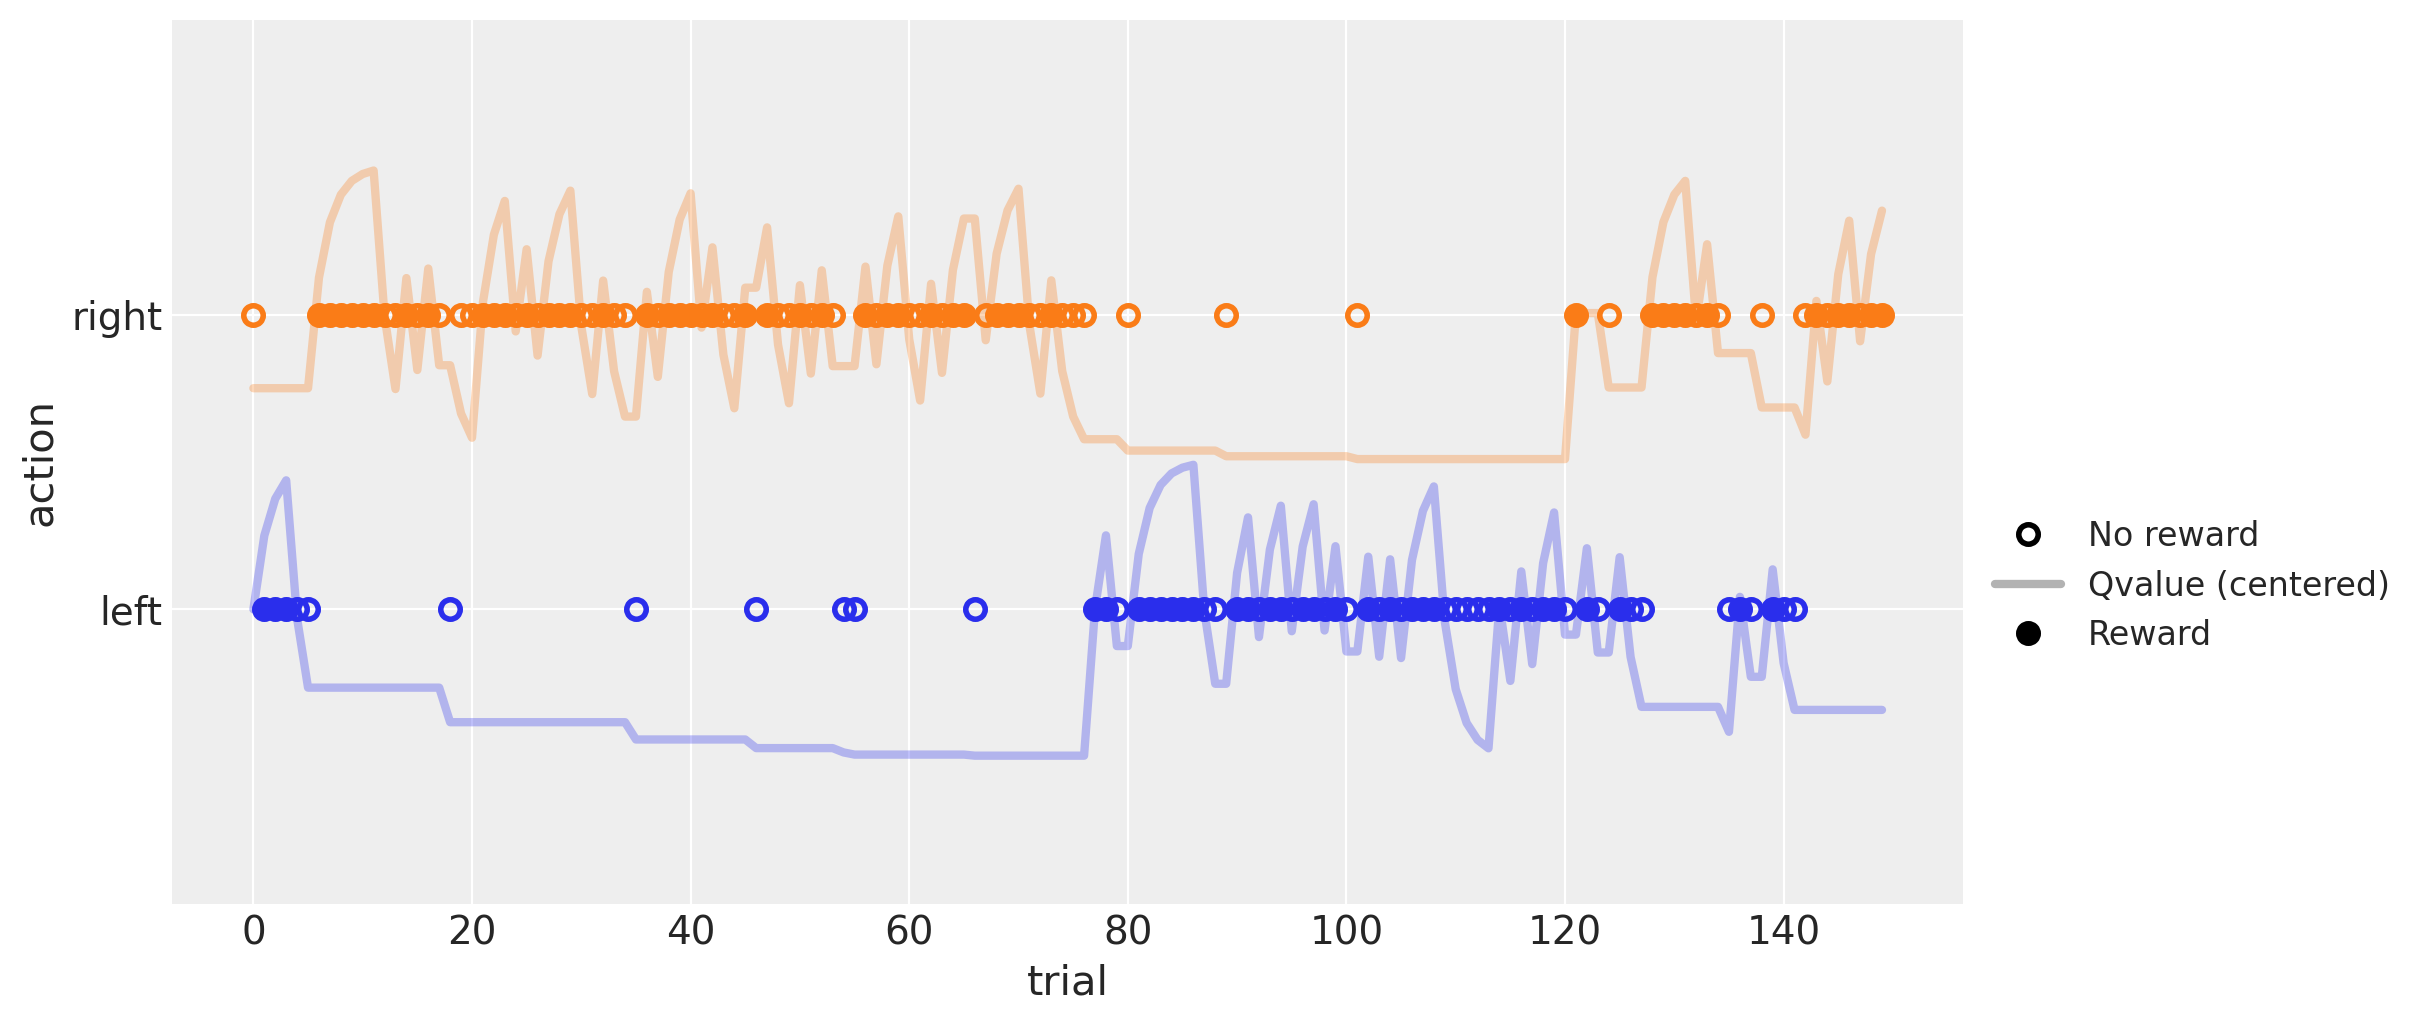

In [21]:
_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(actions))

ax.plot(x, Qs[:, 0] - 0.5 , c="C0", lw=3, alpha=0.3)
ax.plot(x, Qs[:, 1] + 0.5, c="C1", lw=3, alpha=0.3)

s = 7
lw = 2

cond = (actions == 0) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C0", mew=lw) 
# mfc: marker face color, mec: marker edge color
# mew: marker edge width, ms: marker size
# filled circle or empty circle
cond = (actions == 0) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C0", mec="C0", mew=lw)

cond = (actions == 1) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C1", mew=lw)

cond = (actions == 1) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C1", mec="C1", mew=lw)

ax.set_yticks([0, 1], ["left", "right"])
ax.set_ylim(-1, 2)
ax.set_ylabel("action")
ax.set_xlabel("trial")

# Not for plot, just for legend
reward_artist = Line2D([], [], c="k", ls="none", marker="o", ms=s, mew=lw, label="Reward")
no_reward_artist = Line2D(
    [], [], ls="none", marker="o", mfc="w", mec="k", ms=s, mew=lw, label="No reward"
)
Qvalue_artist = Line2D([], [], c="k", ls="-", lw=3, alpha=0.3, label="Qvalue (centered)")

ax.legend(handles=[no_reward_artist, Qvalue_artist, reward_artist], fontsize=12, loc=(1.01, 0.27));

### Estimating the learning parameters via Maximum Likelihood
* I start by doing it via Maximum Likelihood Estimation (MLE). 
* This requires writing a custom function that computes the likelihood of the data given a potential $\alpha$ and $\beta$.
* And the fixed observed actions and rewards (actually the function computes the negative log likelihood, in order to avoid underflow issues).



In [22]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = logp_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(logp_actions[1:])

In [26]:
llik_td([true_alpha, true_beta], *(actions, rewards)) # -log likelihood of the data given the true parameters

47.41893609720702

* Note: 실제 행동과 보상의 data를(사실은 generate fake data에서 얻어진) 바탕으로 Q value를 delta rule에 따라 학습시키고, 그에 따라 계산되는 action probability를 log likelihood를 통해 계산한다.
* 여기서 action probability는 softmax를 통해 계산되지만, 나중에 더해지는 action probability는 실제(fake data) data에서 선택된 action의 probability이다.
* 아래에서는 nll을 최소화하는 방향으로 학습시키는 것이다.(그러면 oberved action probability가 가장 커지기 때문) scipy.optimize.minimize를 통해 학습시킨다.
* 하지만 이 방법은 point estimate만을 얻을 수 있다. (MLE는 point estimate를 얻는 방법이다.)

In [28]:
#x0 = [true_alpha, true_beta]
x0 = [0.1, 0.1] # initial guess
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method="BFGS")
print(result)
print("")
print(f"MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})")
print(f"MLE: beta = {result.x[1]:.2f} (true value = {true_beta})")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 47.05081454110277
        x: [ 5.047e-01  5.707e+00]
      nit: 11
      jac: [-9.537e-07  0.000e+00]
 hess_inv: [[ 7.280e-03 -2.412e-02]
            [-2.412e-02  8.694e-01]]
     nfev: 57
     njev: 19

MLE: alpha = 0.50 (true value = 0.5)
MLE: beta = 5.71 (true value = 5)


#### Vectorized version
* pymc를 활용한 구현으로 넘어가기 전에, vectorized version으로 구현해보자.

In [29]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype="float64")
    Qs[0] = 0.5
    for t, (a, r) in enumerate(
        zip(actions[:-1], rewards[:-1])
    ):  # The last Q values were never used, so there is no need to compute them
        Qs[t + 1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t + 1, 1 - a] = Qs[t, 1 - a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    logp_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the logp_actions for the observed actions
    logp_actions = logp_actions[np.arange(len(actions)), actions]
    return -np.sum(logp_actions[1:])

In [30]:
llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

47.41893609720702

In [31]:
%timeit llik_td([true_alpha, true_beta], *(actions, rewards))

5.28 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%timeit llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

253 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


* vectorized version is faster

### Estimating the learning parameters via PyMC
* pymc에 적합하도록 pytensor를 사용한다

In [34]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [36]:
# Transform the variables into appropriate PyTensor objects
rewards_ = pt.as_tensor_variable(rewards, dtype="int32")
actions_ = pt.as_tensor_variable(actions, dtype="int32")

alpha = pt.scalar("alpha")
beta = pt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * pt.ones((2,), dtype="float64")

# Compute the Q values for each trial
Qs, _ = pytensor.scan(
    fn=update_Q, sequences=[actions_, rewards_], outputs_info=[Qs], non_sequences=[alpha]
)

# Apply the softmax transformation
Qs = Qs * beta
logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

# Calculate the negative log likelihod of the observed actions
logp_actions = logp_actions[pt.arange(actions_.shape[0] - 1), actions_[1:]]
neg_loglike = -pt.sum(logp_actions)

In [38]:
pytensor_llik_td = pytensor.function(
    inputs=[alpha, beta], outputs=neg_loglike, on_unused_input="ignore"
)
result = pytensor_llik_td(true_alpha, true_beta)
float(result) 

47.418936097206995